**NOTE:** This notebook uses dimensionless equations and quantities. My Overleaf notes detail the exact scaling relations.

In [15]:
# import packages
import numpy as np
import scipy.integrate as integrate
import scipy.misc
import time

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation

from matplotlib import cm
from matplotlib.ticker import LinearLocator
## set default plot size
plt.rcParams["figure.figsize"] = (10, 7)
## set global font size
plt.rcParams.update({'font.size':14})

import astropy.units as u
from astropy import constants as const

# Galactic phase mixing animation

Let's plot the time evolution of a first-order perturbation: Essentially, every particle follows a circular orbit with frequency $\Omega(J)$. This recreates the Gaia snail shape.

In [27]:
# define Omega, dOmega/dJ
def Omega(J):
    '''
    
    Eq. 8 of Tremaine et al. (2023); orbital frequency.
    
    Here, we interpolate between the low-J and high-J regimes for Omega.
    The interpolated function has form a / (1 + b*J)^{1/3}. 
    
    In this function, J is dimensionless. J=1 corresponds to sigma*z_0 in
    physical units.
    
    '''
    
    a = 1 / np.sqrt(2)
    b = 3*np.sqrt(2) / (np.pi**2)
    
    num = a
    denom = (1 + b*J)**(1/3)
    return num / denom

def dOmega_dJ(J):
    '''
    Derivative of Omega(J), assuming that Omega(J) = a / (1 + b*J)^{1/3}. I got
    this expression for the derivative from Wolfram Alpha.
    
    '''
    
    a = 1 / np.sqrt(2)
    b = 3*np.sqrt(2) / (np.pi**2)
    
    num = -a*b/3
    denom = (1 + b*J)**(4/3)

    return num / denom

Below is an approximate function for converting from action-angle to Cartesian coordinates. Within the next couple weeks, I plan to properly (i.e., numerically) evaluate the conversion between these two coordinate systems.

In [3]:
## basic function for converting (thetas, Js) to (x_vals, y_vals)

def pol2cart_meshgrid(thetas, Js):
    '''
    Given a meshgrid of angles and actions (thetas, Js), return the 
    corresponding meshgrid in Cartesian coordinates.
    
    '''
    
    xs = np.sqrt(Js) * np.cos(thetas)
    ys = np.sqrt(Js) * np.sin(thetas)
    
    return xs, ys

In [4]:
# define phase mixing (i.e., a first-order phase mixing solution for n=1)
def delta_f_phase_mixing(theta, J, t, A_0=1, t_i=0, theta_i=0):
    '''
    Eq. 1 of Tremaine et al. (2023). Suppose a generic perturbation 
    at time t_i changes the distribution function f
    by amplitude A_0. For simplicity, only consider the 
    m=1 Fourier component in theta. Then, as a function of time,
    this perturbation evolves as:
    
    delta_f(theta,J,t) = A_0 * cos[theta - Omega(J)(t-t_i) - theta_i]
    
    '''
        
    phase = theta - Omega(J)*(t-t_i) - theta_i
    
    return A_0 * np.cos(phase)

In [23]:
## define hammer params, phase space range

# define the parameters of the two hammers (t_i, n_i, A_i)
t1, t2 = 0, 100
n1, n2 = 1, 3
A1, A2 = 0.1, 0.2

# define ts, thetas, and Js; and, corresponding Cartesian coords
# time range
tmin = 0
tmax = 100
tstep = 0.5
ts = np.arange(tmin, tmax+tstep, tstep)

# angle
theta_min = 0
theta_max = 2*np.pi
num_thetas_sampled = 100
theta_step = theta_max/num_thetas_sampled

# in Scott's paper, the max. value of (v/sigma)*(z/z_0) ~ 20 in Fig. 3, and 
# from eq. 7, J is roughly prop to v*z.
J_min = 0
J_max = 20
J_step = 0.02

thetas = np.arange(theta_min, theta_max, theta_step)
Js = np.arange(J_min, J_max, J_step)
# thetas, Js are generated from a meshgrid 
thetas, Js = np.meshgrid(thetas, Js) # both thetas and Js has shape (# of Js, # of thetas)

x_vals, y_vals = pol2cart_meshgrid(thetas, Js)


In [11]:
## plot phase mixing at 1 timepoint
# plt.clf()
# fig, ax = plt.subplots(1,1,figsize=(12,10))

# # test that we can plot delta_f at a given t
# Z = delta_f_phase_mixing(thetas, Js, 0)

# im = ax.pcolormesh(x_vals,y_vals,Z,cmap=cm.coolwarm, animated=True, shading='auto')

# fig.colorbar(im, ax=ax)

# ax.set_xlabel(r"$\sqrt{J}$ cos($\theta$)")
# ax.set_ylabel(r"$\sqrt{J}$ sin($\theta$)")
# ax.set_title("$\delta f$")

# plt.show()

<ipython-input-12-bdd299d0a2ca>:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  quad1 = ax.pcolormesh(x_vals,y_vals,Z, cmap=cm.coolwarm, animated=True, shading='auto')


t = 0.0
Elapsed t: 0.2 seconds
t = 0.0
Elapsed t: 0.2 seconds
t = 0.0
Elapsed t: 0.2 seconds
t = 10.0
Elapsed t: 9.0 seconds
t = 20.0
Elapsed t: 17.3 seconds
t = 30.0
Elapsed t: 25.7 seconds
t = 40.0
Elapsed t: 33.9 seconds
t = 50.0
Elapsed t: 42.0 seconds
t = 60.0
Elapsed t: 50.2 seconds
t = 70.0
Elapsed t: 58.3 seconds
t = 80.0
Elapsed t: 66.5 seconds
t = 90.0
Elapsed t: 74.6 seconds
t = 100.0
Elapsed t: 82.7 seconds


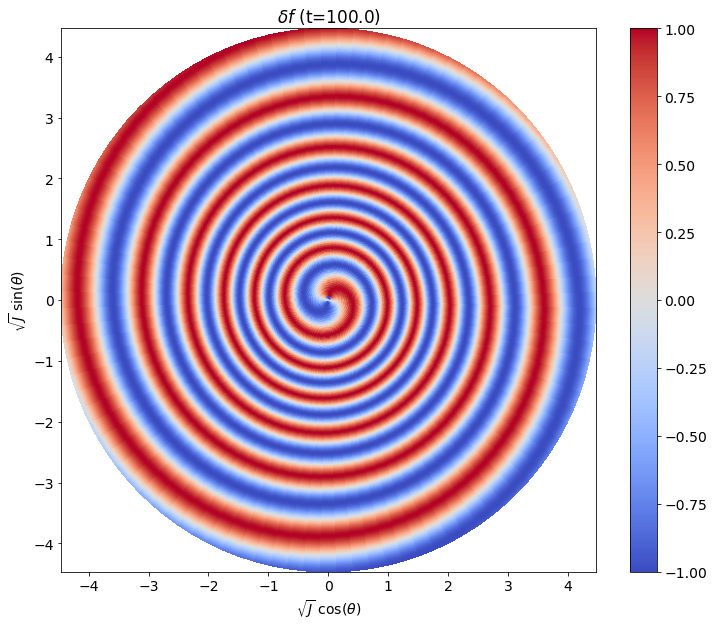

In [12]:
## galactic phase mixing animation
fig, ax = plt.subplots(1,1,figsize=(12,10))

Z = delta_f_phase_mixing(thetas, Js, 0)
# quad mesh
quad1 = ax.pcolormesh(x_vals,y_vals,Z, cmap=cm.coolwarm, animated=True, shading='auto')
fig.colorbar(quad1, ax=ax)

ax.set_xlabel(r"$\sqrt{J}$ cos($\theta$)")
ax.set_ylabel(r"$\sqrt{J}$ sin($\theta$)")

def init():
    quad1.set_array([])
    return quad1

start = time.time()

def updatefig(num):
    # global im
    t = ts[num]
    if ((t % 10) == 0):
        print("t = " + str(t))
        print(f'Elapsed t: {np.round(time.time() - start, 1)} seconds')

    Z = delta_f_phase_mixing(thetas, Js, t)
    #Z = Z[:-1, :-1]
    quad1.set_array(Z.ravel())
    
    ax.set_title('$\delta f$ (t=' + str(t) + ')')
    
    return quad1,


ani = animation.FuncAnimation(fig, updatefig, interval=100, frames=len(ts), blit=True)

ani.save("Gaia_pm_polar_temp.mp4")

# Galactic echo animation

In [21]:
## define the slab Hamiltonian, f0, and f0's first+second derivatives
def Hamiltonian(J):
    '''
    Computes the Hamiltonian of our system by integrating Omega(J)
    from 0 to J. (Underneath Eq. 8 in Scott's paper, it's stated that
    Omega = dH/dJ.) We assume that Omega=0 for H=0.
    
    We use Omega = a/(1 + b*J)^(1/3) and its analytical antiderivative.
    
    '''
    
    term1 = np.pi**2 / 4
    b = 3*np.sqrt(2) / (np.pi**2)
    
    term2 = (1 + b*J)**(2/3)
    return term1 * term2

def f_0(J): 
    '''
    Initial distribution function of our system, using Eq. 6 of Scott's
    paper.
    
    '''
    
    return np.exp(-1*Hamiltonian(J)) / np.sqrt(2 * np.pi)

def df0_dJ(J):
    '''
    The derivative of our initial distribution function, f_0(J) ~ exp(-H(J)). 
    We have df_0/dJ = -dH/dJ * exp(-H)/sqrt(2pi) = -Omega(J) * exp(-H)/sqrt(2pi).
    
    '''
    
    return -Omega(J) * np.exp(-1*Hamiltonian(J)) / np.sqrt(2 * np.pi)

def f0_second_deriv(J):
    '''
    The second derivative of our initial distribution function, f_0(J) ~ exp(-H(J)). 
    By product rule, taking the derivative of df_0/dJ yields:
    
    -dOmega/dJ * exp(-H)/sqrt(2pi) + -Omega * [-dH/dJ * exp(-H)]/sqrt(2pi) = 
    -dOmega/dJ * exp(-H)/sqrt(2pi) + (Omega^2)*exp(-H)/sqrt(2pi) = 
    = (-dOmega/dJ + Omega^2) * exp(-H)/sqrt(2pi)
    
    '''
        
    coeff = Omega(J)**2 - dOmega_dJ(J)
    
    return coeff * np.exp(-1*Hamiltonian(J)) / np.sqrt(2 * np.pi)

## $f$ definitions

In [22]:
## define delta_f/f0 and other components of delta_f for the 2nd-order solution
def deltaf_over_f0(theta, J, t, t1, t2, n1, n2, A1, A2):
    '''
    Represents the relative distribution function delta_f / f0.
    
    '''
    
    return delta_f_full(theta, J, t, t1, t2, n1, n2, A1, A2) / f_0(J)

def f_full(theta, J, t, t1, t2, n1, n2, A1, A2): 
    '''
    Represents the full solution of the distribution function f; 
    i.e., f = f_0 + delta_f.
    
    '''
    
    return f_0(J) + delta_f_full(theta, J, t, t1, t2, n1, n2, A1, A2)

def delta_f_full(theta, J, t, t1, t2, n1, n2, A1, A2): 
    '''
    Represents the full solution to delta_f up to second order.
    
    '''
    
    return delta_f_1(theta, J, t, t1, t2, n1, n2, A1, A2) + \
            delta_f_2(theta, J, t, t1, t2, n1, n2, A1, A2)

def delta_f_1(theta, J, t, t1, t2, n1, n2, A1, A2): 
    '''
    Represents the first-order solution for delta_f given two hammers:
    One with amplitude A1 at time t1, and one with amplitude A2 at time t2.
    
    '''
    
    expr1 = (-2) * n1 * A1 * df0_dJ(J) * np.sin(n1 * (theta - Omega(J)*(t-t1)))
    expr2 = (-2) * n2 * A2 * df0_dJ(J) * np.sin(n2 * (theta - Omega(J)*(t-t2)))
    
    # Heaviside coefficients on each expression
    if (t < t1):
        expr1 = 0
    if (t < t2):
        expr2 = 0
    
    return expr1 + expr2

def delta_f_2(theta, J, t, t1, t2, n1, n2, A1, A2): 
    '''
    Represents the second-order solution for delta_f given two hammers:
    One with amplitude A1 at time t1, and one with amplitude A2 at time t2.
    
    '''
    
    return delta_f_2_pm(theta, J, t, t1, t2, n1, n2, A1, A2) + \
                delta_f_2_echo(theta, J, t, t1, t2, n1, n2, A1, A2)

def delta_f_2_pm(theta, J, t, t1, t2, n1, n2, A1, A2,
                 dOmega_dJ_is_zero=False):
    '''
    Represents the phase-mixing (i.e., non-echo) component of the second-order solution 
    for delta_f given two hammers: One with amplitude A1 at time t1, and one with
    amplitude A2 at time t2.
    
    This formula assumes that A1 and A2 are constant; i.e., independent of J.
    
    '''
    
    # Heaviside function coefficient H(t-t_2), defined to be 0 at 0
    if (t < t2):
        return 0
    
    t_pm = (n1*t1 + n2*t2) / (n1 + n2)
    
    # function that contains the time evolution
    xi = (n1 + n2) * (theta - Omega(J)*(t - t_pm))
        
    expr1 = (-2)*A1*A2 * np.cos(xi) * n1*n2* f0_second_deriv(J)
    expr2 = (-2)*A1*A2 * np.sin(xi) * n1**2 * n2 * (t2-t1) * dOmega_dJ(J) * df0_dJ(J)
    
    # assume that dOmega_dJ = 0
    if dOmega_dJ_is_zero:
        return expr1
    
    return expr1 + expr2
    

def delta_f_2_echo(theta, J, t, t1, t2, n1, n2, A1, A2,
                   dOmega_dJ_is_zero=False):
    '''
    Represents the echo component of the second-order solution for delta_f 
    given two hammers: One with amplitude A1 at time t1, and one with 
    amplitude A2 at time t2. 
    
    This formula assumes that A1 and A2 are constant; i.e., independent of J.
    
    '''
    
    # Heaviside function coefficient H(t-t_2)
    if (t < t2):
        return 0
    
    t_echo = (n2*t2 - n1*t1) / (n2 - n1)
    
    # function that contains the time evolution
    psi = (n2 - n1) * (theta - Omega(J)*(t - t_echo))
        
    expr1 = 2*A1*A2 * np.cos(psi) * n1*n2* f0_second_deriv(J)
    expr2 = (-2)*A1*A2 * np.sin(psi) * n1**2 * n2 * (t2-t1) * dOmega_dJ(J) * df0_dJ(J)
    
    # assume that dOmega_dJ = 0
    if dOmega_dJ_is_zero:
        return expr1
    
    return expr1 + expr2

In [70]:
## define hammer params, phase space range

# define the parameters of the two hammers (t_i, n_i, A_i)
t1, t2 = 0, 100
n1, n2 = 1, 3
A1, A2 = 0.1, 0.2

# define ts, thetas, and Js; and, corresponding Cartesian coords
# time range
tmin = 0
tmax = 300
tstep = 0.5
ts = np.arange(tmin, tmax+tstep, tstep)

# angle
theta_min = 0
theta_max = 2*np.pi
num_thetas_sampled = 100
theta_step = theta_max/num_thetas_sampled

# in Scott's paper, the max. value of (v/sigma)*(z/z_0) ~ 20 in Fig. 3, and 
# from eq. 7, J is roughly prop to v*z.
J_min = 0
J_max = 20
J_step = 0.02

thetas = np.arange(theta_min, theta_max, theta_step)
Js = np.arange(J_min, J_max, J_step)
# thetas, Js are generated from a meshgrid 
thetas, Js = np.meshgrid(thetas, Js) # both thetas and Js has shape (# of Js, # of thetas)

x_vals, y_vals = pol2cart_meshgrid(thetas, Js)


## plot $\delta f/f_0$ in $z,v_z$ space

<ipython-input-71-7baeefe36ae8>:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(x_vals, y_vals, Z,


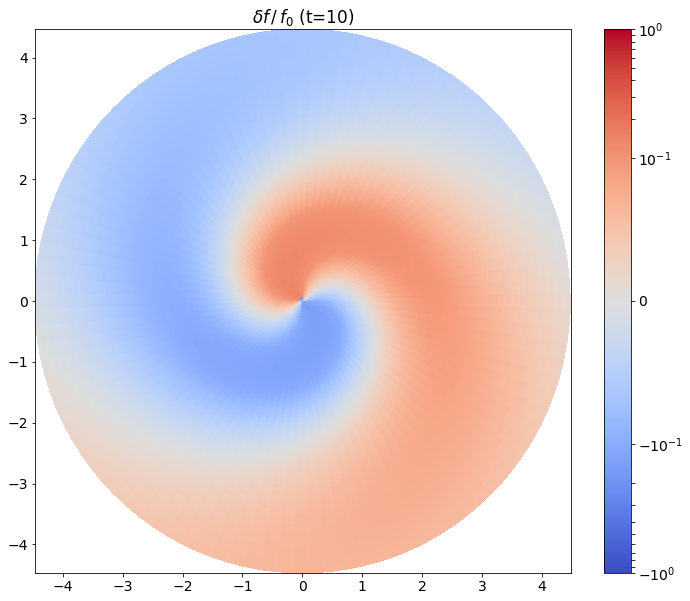

In [71]:
## one snapshot of phase space for 2nd-order solution
t_temp=10
vlimit = 1

Z = deltaf_over_f0(thetas, Js, t_temp, t1=t1, t2=t2, n1=n1, n2=n2, A1=A1, A2=A2)

fig, ax = plt.subplots(1, 1, figsize=(12,10))

im = ax.pcolormesh(x_vals, y_vals, Z, 
                   norm=colors.SymLogNorm(linthresh=1e-1, linscale=1,base=10,
                                          vmin=-vlimit, vmax=vlimit),\
                       cmap=cm.coolwarm,  
                   shading='auto')
cbar = fig.colorbar(im, ax=ax)

ax.set_title('$\delta f \, / \, f_0$ (t=' + str(t_temp) + ')')

plt.show()

<ipython-input-72-265375607129>:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  quad1 = ax.pcolormesh(x_vals, y_vals, Z,


t = 0.0
Elapsed t: 0.4 seconds
t = 0.0
Elapsed t: 0.5 seconds
t = 0.0
Elapsed t: 0.5 seconds
t = 10.0
Elapsed t: 10.1 seconds
t = 20.0
Elapsed t: 19.0 seconds
t = 30.0
Elapsed t: 28.2 seconds
t = 40.0
Elapsed t: 37.4 seconds
t = 50.0
Elapsed t: 46.2 seconds
t = 60.0
Elapsed t: 54.9 seconds
t = 70.0
Elapsed t: 63.7 seconds
t = 80.0
Elapsed t: 72.3 seconds
t = 90.0
Elapsed t: 81.1 seconds
t = 100.0
Elapsed t: 89.7 seconds
t = 110.0
Elapsed t: 99.5 seconds
t = 120.0
Elapsed t: 109.2 seconds
t = 130.0
Elapsed t: 119.2 seconds
t = 140.0
Elapsed t: 129.4 seconds
t = 150.0
Elapsed t: 139.3 seconds
t = 160.0
Elapsed t: 149.1 seconds
t = 170.0
Elapsed t: 158.9 seconds
t = 180.0
Elapsed t: 168.7 seconds
t = 190.0
Elapsed t: 178.5 seconds
t = 200.0
Elapsed t: 188.2 seconds
t = 210.0
Elapsed t: 198.0 seconds
t = 220.0
Elapsed t: 208.4 seconds
t = 230.0
Elapsed t: 218.1 seconds
t = 240.0
Elapsed t: 227.7 seconds
t = 250.0
Elapsed t: 237.3 seconds
t = 260.0
Elapsed t: 247.0 seconds
t = 270.0
Elapsed

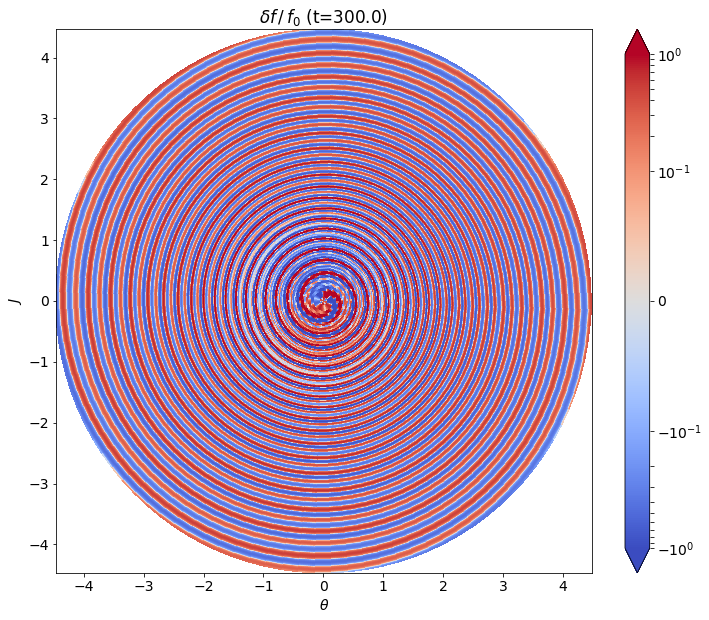

In [72]:
## deltaf/f_0 plotted in J/theta coords

fig, ax = plt.subplots(1,1,figsize=(12,10))

# initialize the color bar
Z = deltaf_over_f0(thetas, Js, 0, t1, t2, n1, n2, A1, A2)
vlimit = 1
quad1 = ax.pcolormesh(x_vals, y_vals, Z, 
                   norm=colors.SymLogNorm(linthresh=1e-1, linscale=1,base=10,
                                          vmin=-vlimit, vmax=vlimit),\
                       cmap=cm.coolwarm,  
                   shading='auto')
fig.colorbar(quad1, ax=ax, extend='both')

ax.set_xlabel(r"$\sqrt{J}$ cos($\theta$)")
ax.set_ylabel(r"$\sqrt{J}$ sin($\theta$)")

# the overdensity at theta=0 as a function of time; ie, delta_n(theta=0, t)
delta_n_array = []

def init():
    quad1.set_array([])
    return quad1

start = time.time()
def updatefig(num):
    
    t = ts[num]
    if ((t % 10) == 0):
        print("t = " + str(t))
        print(f'Elapsed t: {np.round(time.time() - start, 1)} seconds')
        
    Z = deltaf_over_f0(thetas, Js, t, t1, t2, n1, n2, A1, A2)
    
    # integrate over Z at x_val=0, ie, at theta = +-pi/2
    theta_ind = (int) (num_thetas_sampled / 4) # index of theta = pi/2
    delta_n = np.sum(Z[:, theta_ind]) # integrate over "y" at theta=pi/2
    delta_n += np.sum(Z[:, num_thetas_sampled-theta_ind]) # theta=-pi/2
    delta_n_array.append(delta_n)
    
    ## plot delta_f in J vs. theta phase space
    #Z = Z[:-1, :-1]
    quad1.set_array(Z.ravel())
    
    ax.set_title('$\delta f \, / \, f_0$ (t=' + str(t) + ')')

    return im,


ani = animation.FuncAnimation(fig, updatefig, frames=len(ts), interval=100, blit=True)

ani.save("deltaf_over_f0_temp.mp4")

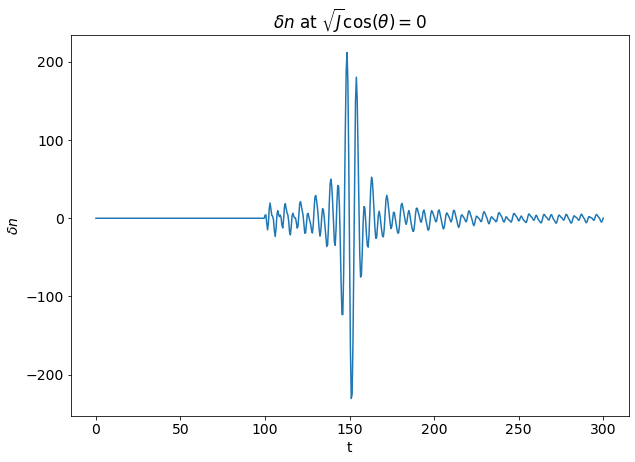

In [76]:
# density at x_val=0
plt.plot(ts, delta_n_array[2:])
plt.title(r'$\delta n$ at $\sqrt{J} \cos(\theta) = 0$')

plt.xlabel('t')
plt.ylabel(r'$\delta n$')

plt.savefig('two_hammers_deltan_polar_temp.png')
plt.show()

np.save("delta_n_array", delta_n_array)

In [74]:
# t after t2 where delta_n peaks 
# (the +2 offset is needed because delta_n_array has 2 extra terms at the start, idk why)
second_hammer_t = (int) (t2 / tstep)
print("delta n peaks at this t:")
ts[np.argmax(np.abs(delta_n_array[(second_hammer_t+2):]))]+t2

delta n peaks at this t:


151.0